In [1]:
import numpy as np
import os
import tensorflow as tf
import iris
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from neural_network_decision_tree import nn_decision_tree
from DataParser import DataParser
from CsvParser  import CsvParser
plt.rcParams["legend.facecolor"] = 'white'
%matplotlib inline

In [2]:
tf.__version__

'1.15.0'

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [4]:
np.random.seed(1943)
tf.set_random_seed(1943)

In [5]:
data_dir        = os.path.join(os.getcwd(), '../datasets')
signal_file     = './08mm/signal_08mm.csv'
background_file = './08mm/background_08mm.csv'
# signal_file     = './2mm/signal_2mm.csv'
# background_file = './2mm/background_2mm.csv'
# signal_file     = 'ap_100MeV_L1L1_loose.csv'
# background_file = 'tritrig-wab-beam_100MeV_L1L1_loose.csv'

In [6]:
background = CsvParser(os.path.join(data_dir, background_file), filter=True)
signal     = CsvParser(os.path.join(data_dir, signal_file), filter=True)

myData     = DataParser(signal=signal, background=background)

[INFO]: Reading CSV file C:\Users\carag\Google Drive\PhD\Classes\CS230\project\repo\cs230-project\final\dndt\../datasets\./08mm/background_08mm.csv found 98304 rows and 11 columns
[INFO]: Found 11 features and 98304 samples
[INFO]: Filtering data
[INFO]: Filtering data keeping these columns ['vzPull', 'vy', 'vz', 'uncM', 'eleZ0', 'posZ0', 'projY']
[INFO]: Reading CSV file C:\Users\carag\Google Drive\PhD\Classes\CS230\project\repo\cs230-project\final\dndt\../datasets\./08mm/signal_08mm.csv found 98304 rows and 11 columns
[INFO]: Found 11 features and 98304 samples
[INFO]: Filtering data
[INFO]: Filtering data keeping these columns ['vzPull', 'vy', 'vz', 'uncM', 'eleZ0', 'posZ0', 'projY']


In [7]:
# Data and Labels
x = myData.X.T
y = convert_to_one_hot(myData.Y, 2).T
d = x.shape[1]

In [8]:
num_cut = [1, 1, 1, 1, 1, 1, 1] # Hyper parameter
num_leaf = np.prod(np.array(num_cut) + 1)
num_class = 2

In [9]:
sess = tf.InteractiveSession()

In [10]:
x_ph = tf.placeholder(tf.float32, [None, d])
y_ph = tf.placeholder(tf.float32, [None, num_class])

In [11]:
cut_points_list = [tf.Variable(tf.random_uniform([i])) for i in num_cut]
leaf_score = tf.Variable(tf.random_uniform([num_leaf, num_class]))

In [12]:
y_pred = nn_decision_tree(x_ph, cut_points_list, leaf_score, temperature=0.1)
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(logits=y_pred, onehot_labels=y_ph))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
opt = tf.train.AdamOptimizer(0.1)
train_step = opt.minimize(loss)

In [14]:
sess.run(tf.global_variables_initializer())

### Run 

In [15]:
epoch = 600 # Hyper parameter
for i in range(epoch):
    _, loss_e = sess.run([train_step, loss], feed_dict={x_ph: x, y_ph: y})
    if i % 200 == 0:
        print(loss_e)
        
error_rate = (1 - np.mean(np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1) == np.argmax(y, axis=1)))
print('error rate %.2f' % error_rate)

0.80681515
0.30919912
0.3085824
error rate 0.13


### Plotting

Background Accuracy 92.64 %
Signal Accuracy 92.06 %


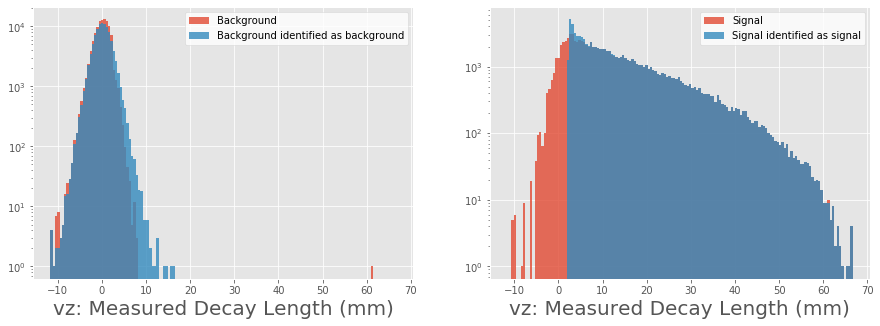

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

nbins = 150

label_pred = np.argmax(y_pred.eval(feed_dict={x_ph: x}), axis=1)
feature_name  = 'vz'
feature_index = myData.DATA_HEADER.index(feature_name)
feature_max = np.max(x[:,feature_index])
feature_min = np.min(x[:,feature_index])

background      = x[label_pred  == 0, feature_index]
background_pred = x[myData.Y[0] == 0, feature_index]
signal          = x[myData.Y[0] == 1, feature_index]
signal_pred     = x[label_pred  == 1, feature_index]
thisAx = ax[0]
b_h  = thisAx.hist(background     , range=(feature_min, feature_max), bins=nbins, alpha=0.8, label='Background')
bp_h = thisAx.hist(background_pred, range=(feature_min, feature_max), bins=nbins, alpha=0.8, label='Background identified as background')

thisAx.set_yscale('log')
thisAx.set_xlabel(feature_name, fontsize=20)

thisAx.legend(loc=1)

thisAx = ax[1]
s_h  = thisAx.hist(signal, range=(feature_min, feature_max), bins=nbins, alpha=0.8, label='Signal')
sp_h = thisAx.hist(signal_pred, range=(feature_min, feature_max), bins=nbins, alpha=0.8, label='Signal identified as signal')


thisAx.set_yscale('log')
thisAx.set_xlabel(feature_name, fontsize=20)

thisAx.legend(loc=1)

background_error  = np.sum(b_h[0] - bp_h[0]) / np.sum(b_h[0])
signal_error = np.sum(s_h[0] - sp_h[0]) / np.sum(s_h[0])
print('Background Accuracy %.2f %%' % ((1-background_error) * 100))
print('Signal Accuracy %.2f %%'     % ((1-signal_error) * 100))

_ = [thisAx.set_xlabel("vz: Measured Decay Length (mm)", fontsize=20) for thisAx in ax]

fig.savefig('dndt.png')
